# HOMEWORK 3

## 1) DATA COLLECTION

### 1.1 Get the list of animes
We start from the list of animes to include in your corpus of documents. In particular, we focus on the top animes ever list. From this list we want to collect the url associated to each anime in the list. The list is long and splitted in many pages. We ask you to retrieve only the urls of the animes listed in the first 400 pages (each page has 50 animes so you will end up with 20000 unique anime urls).

The output of this step is a .txt file whose single line corresponds to an anime's url.

## Solution:
The main idea is to split the work between the retrieving of the html pages (skipping the already stored urls) and the retrieving of the links in the pages.<br>
Once we've defined a way to scrap the urls from the page, we'll iterate over 20000 to get all the pages till that number. At the time of execution the urls retrieved was only 19122, but in other execution it was even 19128, so it depends from the moment you execute that. The file was created in 5-Nov-2021 so the list refers to the content of the site in that day.

In [34]:
#import libraries
import requests
url = 'https://myanimelist.net/topanime.php'
response= requests.get(url)
from bs4 import BeautifulSoup

In [35]:
def get_links_from_soup(soup):
    ''' 
        Given a BeautifulSoup object the functions iterates over all the links in the table rows in the corrisponding page.
        The functions also returns the list containing all the destination (href) of these links
    '''
    anime = []
    for tag in soup.find_all('tr'):
        links = tag.find_all('a')
        for link in links:
            # checking if there is a content in the link
            if type(link.get('id')) == str and len(link.contents[0]) > 1:
                anime.append((link.contents[0], link.get('href')))
    return anime

Do not execute the following three cells!!

In [36]:
tot_list= []
for lim in range(0, 20000, 50):
    
    # The principal page of animelis, so: https://myanimelist.net/topanime.php
    if lim==0:
        new_url = url
    else: # we've to skio the first lim elements
        new_url = url+'?limit='+str(lim)
    response = requests.get(new_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tot_list += get_links_from_soup(soup)

In [129]:
len(tot_list)

19123

In [39]:
with open('out.txt', 'w') as f:
    for n, link in tot_list:
        f.write(link+'\n')

### 1.2. Crawl animes
Once you get all the urls in the first 400 pages of the list, you:

* Download the html corresponding to each of the collected urls.
* After you collect a single page, immediately save its html in a file. In this way, if your program stops, for any reason, you will not lose the data collected up to the * * * stopping point. More details in Important (2).
* Organize the entire set of downloaded html pages into folders. Each folder will contain the htmls of the animes in page 1, page 2, ... of the list of animes.

**Important**

Due to the large amount of pages you need to download, follow the next tips that will help you speeding up several time-consuming operations.

[Save time downloading files] You are asked to crawl a considerable number of pages, which will take plenty of time. To speed up the operation, we suggest you to work in parallel with your group's colleagues or even generate code that works in parallel with all the CPUs available in your computer. In particular, using the same code, each component of the group can be in charge of downloading a subset of pages (e.g., the first 100). PAY ATTENTION: Once obtained all the pages, merge your results into an unique dataset. In fact, the search engine must look up for results in the whole set of documents.

[Save your data] It is not nice to restart a crawling procedure, given its runtime. For this reason, it is extremely important that for every time you crawl a page, you must save it with the name article_i.html, where i corresponds to the number of articles you have already downloaded. In such way, if something goes bad, you can restart your crawling procedure from the i+1-th document.

## Solution:
Once the website has to protect itself, it will block our requests if they are too much, so i've looked first if there's an error and, in that case, the program stops for a random range of time.<br>
In this way we've collected only cleaned pages (not the one containing the error button).<br>
The program (that can be found in the [downloder.py](downloader.py) file) has not been run by this notebook, but we've made a CLI version in order to run it from the terminal in how many terminal you want in order to work in parallel.<br>
The specification of that function can be retrieved in that file and even launching it from terminal with the ```--h``` flag only to see the documentation and the usage.

### 1.3 Parse downloaded pages
At this point, you should have all the html documents about the animes of interest and you can start to extract the animes informations. The list of information we desire for each anime and their format is the following:

* **Anime Name** (to save as animeTitle): *String*
* **Anime Type** (to save as animeType): *String*
* **Number of episode** (to save as animeNumEpisode): *Integer*
* **Release and End Dates of anime** (to save as releaseDate and endDate): Convert both release and end date into *datetime format*.
* **Number of members** (to save as animeNumMembers): *Integer*
* **Score** (to save as animeScore): *Float*
* **Users** (to save as animeUsers): *Integer*
* **Rank** (to save as animeRank): *Integer*
* **Popularity** (to save as animePopularity): *Integer*
* **Synopsis** (to save as animeDescription): *String*
* **Related Anime** (to save as animeRelated): Extract all the related animes, but only keep unique values and those that have a hyperlink associated to them. *List of strings*.
* **Characters** (to save as animeCharacters): *List of strings*
* **Voices** (to save as animeVoices): *List of strings*
* **Staff** (to save as animeStaff): Include the staff name and their responsibility/task in a *list of lists*.

In [1]:
import html_parser

## Solution:

All the needed functions are in the [html_parser.py](./html_parser.py) file that contains the relative comments and documentation too.
The only function that has to be called to entirely solve this point is the ```save_tsv_info``` function.<br>
Even if the function that will be called in order to get all the needed data in the tsv format is only one, the function implemented are several and more or less they are grouped in three category:
* support function (to obtain a BeautifulSoup object from the html o to retrieve the datetime format from a string)
* webscraping function: They are the core of this implementation, all of them takes as parameter a BeautifulSoup object and a dictionary and their purpouse is to put into this dictionary as much information as possible starting from the object in input
* applicative function: They allow to directly obtain the data from a file o an index employing the other functions (i.e. ```save_tsv_info```)

### Webscraping:
In order to retrieve the 13 required fields we need first of all to study the structure of the page.<br>
In general the title is simple to retrieve using bs.<br>
The page, in general is structured as a series of nested tables, so we have a huge table with two columns, one for the left menu that contains all the info relatives to the score, the type of the serie, the ranking and so on and the other is the real body of the page, containing the synopsis, the related animes and other required fields.<br>
<newline>
Considering that, we have written a function called ```get_left_attributes``` that retrieves the values for the fields:
* episodes
* start_date
* end_date
* score
* users
* rank
* members
* popularity
* type
These fields are all in one div for each one and this div has the class equal to '*spaceit_pad*', then we have as content of this div a list of values in the form (at exception of the score) ```['\n', name_of_the_value, value]``` then value has to be processed in order to extract the date or the integer and so on.<br>
<newline>

The remaining values can be found in the right column of the huge table inside different divs or subtables.<br>
<newline>

#### Synopsis<br>
Can be found simply in a paragraph with the attribute '*itemprop*' equal to 'description'<br>
#### Related animes<br>
They are inside a dedicated table with class '*anime_detail_related_anime*', in particular we want only the animes for which exists a link, so we'll iterate over all the links in that table and we'll take the different contents returning the unique values
#### Top reviews<br>
The reviews which are visible on the main page of an anime are all inside a div with class name '*spaceit textReadability word-break pt8 mt8*', so we will iterate over each of those divs and collect the contents of each (the review)
#### Staff<br>
In this case (as for the next) the function will work directly on a specific div (the divs that has the class '*detail-characters-list clearfix*')<br>
Given that div we have all the names that we need as content of links so we'll simply iterate over it and collect the data of interest
#### Characters and voices<br>
This div has the same class of the above one, so if we have only one of the two we can distinguish them by the content of an h3 element of the class '*h3_characters_voice_actors*'.<br>
Starting from this div we have other two div in order to split the list in two columns, these divs contains a list of tables, each of them contains only one row and three columns, one for the images of the characters, one for the name of the characters and the third for the voice, so we'll iterate over the row elements and selecting only the second two columns.<br>
From the first and the second we'll get the link element containing the name either of the character or for the voice.
#### Putting all together<br>
It's done with a function that uses each of these subfunction in order to retrieve, given an html page, the content of interest in a dictionary
<newline>

Once we can obtain a dictionary with the data of interest converting and saving it in a tsv file is trivial and it's done by ad-hoc functions. All this work is encapsulated in the funciton ```save_tsv_info``` that takes the ranges of the page for which we that we want to save the scraped tsv, the base directory where these page are stored and the destination directory over which the outputs will be stored.

In [ ]:
html_parser.get_total_info('../data/html_pages/article_00000.html')

{'title': 'Fullmetal Alchemist: Brotherhood',
 'type': 'TV',
 'episodes': 64,
 'start_date': datetime.datetime(2009, 4, 5, 0, 0),
 'end_date': datetime.datetime(2010, 7, 4, 0, 0),
 'score': 9.16,
 'users': 1622384,
 'ranked': 1,
 'popularity': 3,
 'members': 2675906,
 'synopsis': "After a horrific alchemy experiment goes wrong in the Elric household, brothers Edward and Alphonse are left in a catastrophic new reality. Ignoring the alchemical principle banning human transmutation, the boys attempted to bring their recently deceased mother back to life. Instead, they suffered brutal personal loss: Alphonse's body disintegrated while Edward lost a leg and then sacrificed an arm to keep Alphonse's soul in the physical realm by binding it to a hulking suit of armor.",
 'related_anime': ['Fullmetal Alchemist: Brotherhood - 4-Koma Theater',
  'Fullmetal Alchemist: Brotherhood Specials',
  'Fullmetal Alchemist',
  'Fullmetal Alchemist: The Sacred Star of Milos'],
 'characters': ['Elric, Edward

For each anime, you create an anime_i.tsv file of this structure:

animeTitle \t animeType \t  ... \t animeStaff

## Solution:
In this case we've simply runned the function ```save_tsv_info``` starting from 0 to 19123 (the total number of the pages) in order to get all the necessary.
An example of the output of the funcion that gets the tsv is the following:

In [ ]:
header, content = html_parser.get_tsv_from_idx(0)
print(f"The header of the tsv table is the following:\n\t{header}")
print()
print(f"The content for the 0-th page (the one of the dictionary above) is the following:\n\t{content}")

The header of the tsv table is the following:
	title	type	episodes	start_date	end_date	score	users	ranked	popularity	members	synopsis	related_anime	characters	voices	staff

The content for the 0-th page (the one of the dictionary above) is the following:
	Fullmetal Alchemist: Brotherhood	TV	64	2009-04-05 00:00:00	2010-07-04 00:00:00	9.16	1622384	1	3	2675906	After a horrific alchemy experiment goes wrong in the Elric household, brothers Edward and Alphonse are left in a catastrophic new reality. Ignoring the alchemical principle banning human transmutation, the boys attempted to bring their recently deceased mother back to life. Instead, they suffered brutal personal loss: Alphonse's body disintegrated while Edward lost a leg and then sacrificed an arm to keep Alphonse's soul in the physical realm by binding it to a hulking suit of armor.	['Fullmetal Alchemist: Brotherhood - 4-Koma Theater', 'Fullmetal Alchemist: Brotherhood Specials', 'Fullmetal Alchemist', 'Fullmetal Alchemist: The Sa

## Getting the TSVs!!!
Do NOT run the cell below!

In [ ]:
html_parser.save_tsv_info(0, 19124) # We've used the default directory for source and dest, see the code for details

## 2. SEARCH ENGINE
Let's create two simple search engines which – given as input a query – will return the animes which match the query.

We will start by importing the libraries we will need, notably `nltk` and a custom module `search_eng.py` where we defined the functions we will use.

In [56]:
import pandas as pd
import csv

import search_eng

import nltk
from nltk.stem import SnowballStemmer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/edoardo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/edoardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 2.1. Conjunctive query
Let's first import the dataset we scraped earlier as a `pandas` dataframe.

Given that the file can contain data that are not so clean, we have to use some special attributes of the read_table function in order to retrieve a dataframe containing all the information of interest.

As expected, the dataframe contains exactly 19123 rows indexed from 0 to 19122

In [3]:
def import_df(path = "../data/tsv_files/total_pages.tsv"):
    return pd.read_table(path,
                         delimiter = "\t",
                         header = "infer",
                         quoting = csv.QUOTE_NONE, 
                         error_bad_lines = False)

df = import_df()
df.info()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19123 entries, 0 to 19122
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          19123 non-null  object 
 1   type           19123 non-null  object 
 2   episodes       19123 non-null  object 
 3   start_date     19123 non-null  object 
 4   end_date       19123 non-null  object 
 5   score          19123 non-null  object 
 6   users          19122 non-null  object 
 7   ranked         19122 non-null  object 
 8   popularity     19122 non-null  float64
 9   members        19122 non-null  float64
 10  synopsis       19122 non-null  object 
 11  related_anime  19121 non-null  object 
 12  characters     19121 non-null  object 
 13  voices         19121 non-null  object 
 14  staff          19121 non-null  object 
 15  top_reviews    19121 non-null  object 
dtypes: float64(2), object(14)
memory usage: 2.3+ MB


In order to be indexed, all the synopses must first be preprocessed; this includes tokenizing the whole synopsis, then removing stopwords, punctuations et similia, and finally stemming the words, using NLTK's SnowballStemmer.

We will put the preprocessed synopsises into a new `df` column.

In [4]:
stemmer = SnowballStemmer("english")

df['synopsis_clean'] = df.apply(lambda row: search_eng.preprocess(row['synopsis'], stemmer), 
                                axis = 'columns')

### 2.1.1) Create your index!
We won't look for the query directly into the dataframe. Instead, we will create a vocabulary of all the words we just obtained from the preprocessing, where each of the word is labelled with a unique number.

The vocabulary is a dictionary with a structure like this:

```
{
    word_1: word_id_1,
    word_2: word_id_2,
    ...
}
```

In [9]:
# only execute this cell the first time or 
# when the preprocessing changes!

vocab = search_eng.create_vocab(df['synopsis_clean'])

search_eng.save_dict_to_file(vocab, 
                             "../shared_stuff/indexes/synopsis/vocabulary.json")

Let's import the vocabulary we created

In [114]:
vocab = search_eng.read_dict_from_file("../shared_stuff/indexes/synopsis/vocabulary.json")

We will use the vocabulary to create an Inverted Index, a dictionary where the words (i.e. the numbers assigned to them in the vocabulary) are the keys and the list of the documents they are in are the values.

In short, it will have a structure like this:

```
{
    term_id_1: [document_1, document_2, document_4],
    term_id_2: [document_1, document_3, document_5, document_6],
    ...
}
```

where `term_id_i` is the number given to the word in the vocabulary and `document_i` is the ID of the document that contains the word.

In [11]:
# only execute this cell the first time or 
# when the preprocessing/vocabulary change!

inv_idx = search_eng.create_inv_idx(df['synopsis_clean'], vocab)

search_eng.save_dict_to_file(inv_idx, 
                             "../shared_stuff/indexes/synopsis/inv_idx.json")

Let's import the Inverted Index

In [113]:
inv_idx = search_eng.read_dict_from_file("../shared_stuff/indexes/synopsis/inv_idx.json")

### 2.1.2) Execute the query
We can finally execute the query leveraging the Inverted Index we created.

Since it's a conjunctive query (AND), the results – if any – will be the animes whose synopsis contains **all** the terms in the query.

If the search is successful (at least one result), the function `get_df_entries` will print out a table with the titles of the animes that were found, their synopsis and the URLs to their respective MyAnimeList pages.

In [82]:
query = search_eng.parse_query(input().split(), vocab, stemmer)

# if at least one word in the query
# is in the vocabulary
if query:
    
    results = search_eng.get_results(query, inv_idx)

    df_entries = search_eng.get_df_entries(df, results)

    if df_entries.size != 0: 
        display(df_entries)

 volleyball high school tournament


,animeTitle,animeDescription,animeUrl
819,Haikyuu!!: Riku vs. Kuu,An intense battle rages on at the Tokyo Qualif...,https://myanimelist.net/anime/40262/Haikyuu__R...
124,Haikyuu!! (Haikyu!!),Inspired after watching a volleyball ace nickn...,https://myanimelist.net/anime/20583/Haikyuu
53,Haikyuu!! Second Season (Haikyu!! 2nd Season),Following their participation at the Inter-Hig...,https://myanimelist.net/anime/28891/Haikyuu_Se...
13334,Shoujo Fight: Norainu-tachi no Odekake,"The story follows Neri Ooishi, a high school g...",https://myanimelist.net/anime/7092/Shoujo_Figh...


### 2.2) Conjunctive query & Ranking score
For the second search engine, given a query, we want to get the top-k documents related to the query, by sorting them by their similarity with the query.

In order to do so, we will use a heap data structure leveraging the `heapq` module, and will define functions that compute the tfIdf score of a document and compute the Cosine similarity as the scoring function.

### 2.2.1) Inverted index

We need to create and store a new Inverted Index where each document is coupled in a tuple with its tfIdf score:

```
{
    term_id_1:[(document1, tfIdf_{term,document1}), (document2, tfIdf_{term,document2}), (document4, tfIdf_{term,document4}), ...],
    term_id_2:[(document1, tfIdf_{term,document1}), (document3, tfIdf_{term,document3}), (document5, tfIdf_{term,document5}), (document6, tfIdf_{term,document6}), ...],
    ...
}
```

In [124]:
# only execute this cell the first time or 
# when the preprocessing changes!

inv_idx, idf = search_eng.create_inv_idx2(df['synopsis_clean'], vocab)
search_eng.save_dict_to_file(inv_idx, "../shared_stuff/indexes/synopsis/inv_idx_tfldf.json")

# let's save idf too, as they are invariant and we will need them for query
search_eng.save_dict_to_file(idf, "../shared_stuff/indexes/synopsis/idf.json")

Let's import the Inverted Index and the idf scores

In [125]:
inv_idx = search_eng.read_dict_from_file("../shared_stuff/indexes/synopsis/inv_idx_tfldf.json")

idf = search_eng.read_dict_from_file("../shared_stuff/indexes/synopsis/idf.json")

### 2.2.2) Execute the query

Let's find the top $k = 10$ animes that match the query (i.e. whose synopsis contains all terms in the query) with the largest similarity (a float between 0 and 1).

In [128]:
import heapq

k = 10

query = search_eng.parse_query(input().split(), vocab, stemmer)

if query:
    
    tfidf_q, tfidf_docs = search_eng.tfidf_query(df['synopsis_clean'], query, inv_idx, idf)
    
    #defining heap to finding k docs with largest cos similiarity
    if len(tfidf_docs) < k:
        larg_doc = {d: search_eng.cosine_similiarity(tfidf_q, tfidf_docs[d]) for d in tfidf_docs.keys()}
    else:
        heap = [(search_eng.cosine_similiarity(tfidf_q, tfidf_docs[key]), key) for key,value in tfidf_docs.items()]
        larg_doc = {d: simil for (simil, d) in heapq.nlargest(k, heap)}
    
    df_entries = search_eng.get_df_entries(df, set(larg_doc.keys()), simil = larg_doc)
    
    if df_entries.size != 0: 
        display(df_entries)

 volleyball high school tournament


,animeTitle,animeDescription,animeUrl,Similarity
53,Haikyuu!! Second Season (Haikyu!! 2nd Season),Following their participation at the Inter-Hig...,https://myanimelist.net/anime/28891/Haikyuu_Se...,1.000000
819,Haikyuu!!: Riku vs. Kuu,An intense battle rages on at the Tokyo Qualif...,https://myanimelist.net/anime/40262/Haikyuu__R...,0.951320
13334,Shoujo Fight: Norainu-tachi no Odekake,"The story follows Neri Ooishi, a high school g...",https://myanimelist.net/anime/7092/Shoujo_Figh...,0.920541
124,Haikyuu!! (Haikyu!!),Inspired after watching a volleyball ace nickn...,https://myanimelist.net/anime/20583/Haikyuu,0.912381


By executing the same query we chose in 2.1, we can see how the results were the same – as expected – but were sorted differently.

## 3. DEFINE A NEW SCORE!

Now it's your turn. Build a new metric to rank animes based on the queries of their users.

In this scenario, a single user can give in input more information than the single textual query, so you need to take into account all this information, and think a creative and logical way on how to answer at user's requests.

#### Practically:

The user will enter you a text query. As a starting point, get the query-related documents by exploiting the search engine of Step 2.1.<br>
<newline>

Once you have the documents, you need to sort them according to your new score. In this step you won't have anymore to take into account just the plot of the documents, you must use the remaining variables in your dataset (or new possible variables that you can create from the existing ones...). You must use a heap data structure (you can use Python libraries) for maintaining the top-k documents.<br>
<newline>

**Q: How to sort them?** <br>
**A: Allow the user to specify more information** that you find in the documents, and define a new metric that ranks the results based on the new request. You can also use other information regarding the anime to score some animes above others.<br>
N.B.: You have to define a scoring function, not a filter!

The output, must contain:

* **animeTitle**
* **animeDescription**
* **Url**
* **The new similarity score of the documents** with respect to the query


Are the results you obtain better than with the previous scoring function. Explain and compare results


## Solution

The basic idea is that a user can search for the words in the synopsis in the 2.1 point, so here we want to give the possibility to the user to query the data in the points he preferes from:
* title
* staff
* characters
* voices
* synopsis

Given that the query shoudld be in the form:<br>
"```word1 word2 [where_to_search] word3 word4 [where_t_s2] ...```"<br>
and the program will return the documents that contains word1 AND word2 in the field 'where_to_search' AND contains word3 AND word4 in the field 'where_t_s2'
<newline>

Hence the idea is to create an inverted index for each of thie fields and then parse the query and obtain the document that match it.<br>
We need to sort this document accordingly with a customized score and return for each of them the neccessarly info

In [1]:
from advanced_queryer import *
from search_eng import *

In [6]:
import ast

def preprocessing_staff(df):
    df['str_staff']= df.apply(lambda row: ' '.join([el[0] for el in ast.literal_eval(row['staff'])]), 
                                axis = 'columns')
    print(f"[Staff]: Converted all the lists in strings, starting the preprocessing...")
    prepr_staff = df.apply(lambda row: (preprocess(row['str_staff'], SnowballStemmer('english'))), axis = 'columns')
    return prepr_staff

def preprocessing_voices(df):
    df['str_voices'] = df.apply(lambda row: ' '.join(ast.literal_eval(row['voices'])), 
                                    axis = 'columns')
    print(f"[Voices]: Converted all the lists in strings, starting the preprocessing...")
    return df.apply(lambda row: (preprocess(row['str_voices'], SnowballStemmer('english'))), axis = 'columns')

def preprocessing_characters(df):
    df['str_characters'] = df.apply(lambda row: ' '.join(ast.literal_eval(row['characters'])), 
                                    axis = 'columns')
    print(f"[Characters]: Converted all the lists in strings, starting the preprocessing...")
    return df.apply(lambda row: (preprocess(row['str_characters'], SnowballStemmer('english'))), axis = 'columns')

def preprocessing_title(df):
    print(f"[Title]: Starting the preprocessing...")
    return df.apply(lambda row: (preprocess(row['title'], SnowballStemmer('english'))), axis = 'columns')

def preprocessing_synopsis(df):
    print(f"[Synopsis]: Starting the preprocessing...")
    return df.apply(lambda row: (preprocess(row['synopsis'], SnowballStemmer('english'))), axis = 'columns')

In [7]:
'''
Preprocessing staff,voices,characters and title
'''

prepr_staff = preprocessing_staff(df)
print("[Staff]: Done.")

prepr_voices = preprocessing_voices(df)
print("[Voices]: Done.")

prepr_characters = preprocessing_characters(df)
print("[Characters]: Done.")

prepr_title = preprocessing_title(df)
print("[Title]: Done.")

[Staff]: Converted all the lists in strings, starting the preprocessing...
[Staff]: Done.
[Voices]: Converted all the lists in strings, starting the preprocessing...
[Voices]: Done.
[Characters]: Converted all the lists in strings, starting the preprocessing...
[Characters]: Done.
[Title]: Starting the preprocessing...
[Title]: Done.


In [8]:
voc_staff = create_vocab(prepr_staff)
print("[Staff]: Created vocabulary")

voc_voices = create_vocab(prepr_voices)
print("[Voices]: Created vocabulary")

voc_characters = create_vocab(prepr_characters)
print("[Characters]: Created vocabulary")

voc_title = create_vocab(prepr_title)
print("[Title]: Created vocabulary")

[Staff]: Created vocabulary
[Voices]: Created vocabulary
[Characters]: Created vocabulary
[Title]: Created vocabulary


In [ ]:
'''
Creation of inverted indexes of staff,voices,character and title
'''

idx_staff = create_inv_idx(prepr_staff, voc_staff)
print("[Staff]: Created index")

idx_voices = create_inv_idx(prepr_voices, voc_voices)
print("[Voices]: Created index")

idx_characters = create_inv_idx(prepr_characters, voc_characters)
print("[Characters]: Created index")

idx_title = create_inv_idx(prepr_title, voc_title)
print("[Title]: Created index")

In [ ]:
idx_dir = os.path.join('..', 'shared_stuff', 'indexes')
staff_dir = os.path.join(idx_dir, 'staff')
voices_dir = os.path.join(idx_dir, 'voices')
ch_dir = os.path.join(idx_dir, 'characters')
title_dir = os.path.join(idx_dir, 'title')
syns_dir = os.path.join(idx_dir, 'synopsis')

tot_dirs = {'staff': staff_dir, 'voices': voices_dir, 'characters': ch_dir, 'title': title_dir}
for d in tot_dirs.values():
    if not os.path.exists(d):
        os.mkdir(d)

In [ ]:
'''
Save all the vocabularies in the corresponding json files
'''

for p in [staff_dir, voices_dir, ch_dir, title_dir]:
    idx = os.path.join(p, 'inv_idx.json')
    voc = os.path.join(p, 'vocabulary.json')

    if os.path.exists(idx) or os.path.join(voc):
        var = input(f"The directory {p} contains an index or vocabulary that will be overwritten do you want to proceed? [y/n]")
        if var=='y':
            continue
        else:
            raise ValueError("Indexes existists!!!")


save_dict_to_file(dct=voc_staff, filename=os.path.join(staff_dir, 'vocabulary.json'))
save_dict_to_file(dct=idx_staff, filename=os.path.join(staff_dir, 'inv_idx.json'))
print("[Staff]: All saved.")

save_dict_to_file(dct=voc_voices, filename=os.path.join(voices_dir, 'vocabulary.json'))
save_dict_to_file(dct=idx_voices, filename=os.path.join(voices_dir, 'inv_idx.json'))
print("[Voices]: All saved.")

save_dict_to_file(dct=voc_characters, filename=os.path.join(ch_dir, 'vocabulary.json'))
save_dict_to_file(dct=idx_characters, filename=os.path.join(ch_dir, 'inv_idx.json'))
print("[Characters]: All saved.")

save_dict_to_file(dct=voc_title, filename=os.path.join(title_dir, 'vocabulary.json'))
save_dict_to_file(dct=idx_title, filename=os.path.join(title_dir, 'inv_idx.json'))
print("[Title]: All saved.")

Here we're fixing the synopsis vocabulary

In [ ]:
prepr_syns = preprocessing_synopsis(df)
print("[Synopsis]: Done.")
voc_syns = create_vocab(prepr_syns)
print("[Synopsis]: Created vocabulary")
idx_syns = create_inv_idx(prepr_syns, voc_syns)
print("[Synopsis]: Created index")

In [ ]:
save_dict_to_file(dct=voc_syns, filename=os.path.join(syns_dir, 'vocabulary.json'))
save_dict_to_file(dct=idx_syns, filename=os.path.join(syns_dir, 'inv_idx.json'))
print("[Synopsis]: All saved.")

In [2]:
p_q = parse_advanced_query("dragon [title] vegeta [characters]")
print(p_q)

['dragon', '[title]', 'vegeta', '[characters]']
{'title': [4998], 'characters': [14666]}


The idea is to assign a similarity score to each documment that has all the words we are searching following the formula:

$\displaystyle \sum_{i=0}^n \frac{q_i\cdot p_i}{d_i} $ 

where:
* $q_i$= *len query in the i-th fielfd*
* $d_i$= *len document in the i-th field*
* $p_i$= *weight of i-th field of he search*

Obviously, fields such as title are more important than synopsis which might be a very long description: the user is able to find relevant results just by writing one word of the title or one main character.
The score is upper-bounded by 1. Nevertheless, it is almost impossible to reach this score since the user should write all the right informations in the appropriate field.

Since, commonly, the query are very short, this method assures good results.

Comparing our scoring function with the previous one, they both share their range between O and 1 but tf idf scoring function reaches more easily values towards 1.


In [6]:
dragonball = "dragon [title] gohan [characters]"
query_anime(df, dragonball, 15)

['dragon', '[title]', 'gohan', '[characters]']


,doc_id,title,description,url,score
0,6339,Dragon Ball GT,Emperor Pilaf finally has his hands on the Bla...,https://myanimelist.net/anime/225/Dragon_Ball_...,0.243333
1,365,Dragon Ball Z,Five years after winning the World Martial Art...,https://myanimelist.net/anime/813/Dragon_Ball_Z\n,0.242564
2,1960,Dragon Ball Super,Seven years after the events of,https://myanimelist.net/anime/30694/Dragon_Bal...,0.241905
3,10958,Super Dragon Ball Heroes,"In May 2018, V-Jump announced a promotional an...",https://myanimelist.net/anime/37885/Super_Drag...,0.183
4,4796,Dragon Ball Z: Saiya-jin Zetsumetsu Keikaku,Dr. Raichii is the only Tsufurujin (the race e...,https://myanimelist.net/anime/984/Dragon_Ball_...,0.125238
5,6340,Dragon Ball Z: Atsumare! Gokuu World,Dragon Ball Z: Atsumare! Goku's World is a Ter...,https://myanimelist.net/anime/6714/Dragon_Ball...,0.125238
6,5373,Dragon Ball: Super Saiya-jin Zetsumetsu Keikaku,Remake of Dragon Ball Z: Plan to Destroy the S...,https://myanimelist.net/anime/10017/Dragon_Bal...,0.125238
7,5660,Dragon Ball Z: Summer Vacation Special,"One peaceful afternoon, the Son family and fri...",https://myanimelist.net/anime/22695/Dragon_Bal...,0.124167
8,1035,Dragon Ball Kai (Dragon Ball Z Kai),"Five years after the events of Dragon Ball, ma...",https://myanimelist.net/anime/6033/Dragon_Ball...,0.109231
9,5048,Dragon Ball Z Movie 03: Chikyuu Marugoto Chouk...,"A mysterious device crashes on planet Earth, c...",https://myanimelist.net/anime/896/Dragon_Ball_...,0.0975


## 4. BONUS Understanding the anime's reviews

In [360]:
import sent_analysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In order to perform a sentiment analysis on the animes' reviews, we can use NLTK's pre-trained sentiment analyzer, called VADER (Valence Aware Dictionary and sEntiment Reasoner).

VADER performs best with 'social media language', i.e. short sentences with slang/abbreviations; since in this case we are dealing with longer and more structured text (though we will only consider the first 500 or so characters of each review), we can analyze each sentence separately and then average the results to get an overall score.

Let's import the `SentimentIntensityAnalyzer` and create an instance of it called `sia`

In [271]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

We don't need to work with every anime on the list, because we expect for animes close in the standings to produce very similar results. Instead, what we mainly want to study is the relationship between the anime's and our sentiment anaysis' score across the whole range of scores.

So let's sample only one review every 10

In [340]:
df_sent = df.copy()

df_sent = df_sent.iloc[::10, :][['title', 'type', 'episodes', 'score', 'top_reviews']]

Before doing any work on the reviews, we should make sure they are ready to be analyzed: each row of the `top_reviews` column must be parsed by `pandas` as a list of strings. 

First, we should remove from the dataframe every anime without reviews

In [341]:
df_sent = df_sent[df_sent['top_reviews'] != "[]"]

We can now parse `top_reviews` using `ast`'s `literal_eval` method 

In [342]:
df_sent['top_reviews'] = df_sent.apply(lambda row: ast.literal_eval(row['top_reviews']),
                                       axis = 'columns')

Then we should get rid of all poorly-scraped reviews, i.e. reviews whose first lines or so weren't actually made up of sentences or only consisted of a short introduction (e.g. 'Spoiler Alert' or similar). 

We can get rid of those by only keeping reviews with at least 100 characters

In [350]:
df_sent['top_reviews'] = df_sent.apply(lambda row: sent_analysis.filter_by_length(row['top_reviews'], 100),
                                       axis = 'columns')

df_sent = df_sent[df_sent['top_reviews'].str.len() > 0]

Finally, we remove from the dataframe every anime without a score and convert the rest to floats

In [351]:
df_sent = df_sent[df_sent['score'] != "None"]

df_sent['score'] = np.array(df_sent['score'], dtype = float)

Now we're ready to perform some sentiment analysis.

We will start by calculating an average `compound` score for the reviews of each anime. As documented in the [official repository](https://github.com/cjhutto/vaderSentiment#about-the-scoring), the compound score is computed by summing the valence scores of each word in the lexicon and it's then normalized between -1 (most extreme negative) and 1 (most extreme positive), with 0 being perfectly neutral.

As mentioned earlier, we will compute the compound score for each sentence of a review, then compute an average for the review, and finally an average for all the reviews of that particular anime.

Let's save the results into a new `polarity_score` column

In [353]:
df_sent['polarity_score'] = df_sent.apply(lambda row: sent_analysis.score_of_anime(row['top_reviews'], sia),
                                          axis = 'columns')

How are the polarity scores distributed?

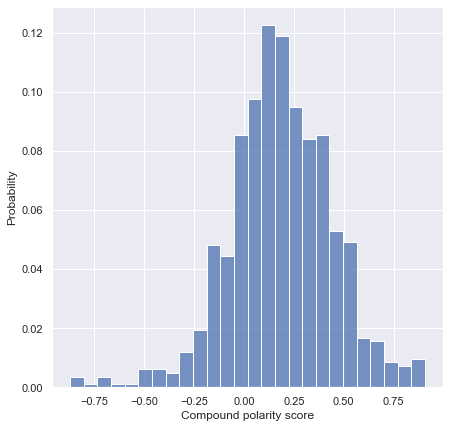

count    832.000000
mean       0.184468
std        0.260445
min       -0.872000
25%        0.027007
50%        0.173715
75%        0.355588
max        0.908100
Name: polarity_score, dtype: float64

In [695]:
sns.histplot(df_sent['polarity_score'], stat = "probability")
plt.xlabel("Compound polarity score")
plt.show()

df_sent['polarity_score'].describe()

Generally, it looks like most of the reviews we scraped – those on the main page of the anime – show a positive sentiment.

Let's actually quantify how many can be considered "positive", "negative" or "neutral", by setting these thresholds:

$\text{Positive}\;\;\: if\; \text{compound_score} \geq 0.2$<br>
$\text{Negative}\;\; if\; \text{compound_score} \leq -0.2$<br>
$\text{Neutral}\;\;\:  otherwise$

We can assign this classification to a new column in the dataframe

In [430]:
df_sent['sentiment'] = df_sent.apply(lambda row: sent_analysis.sent_of_anime(row['polarity_score']),
                                     axis = "columns")

We get that the about half of animes – given those thresholds – can be considered positively received, with only a small portion being negatively received.

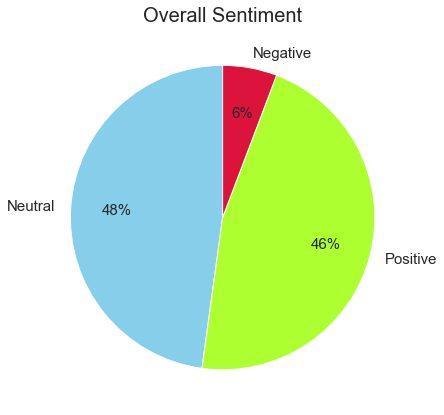

Number of animes classified with the


sentiment
Negative     48
Neutral     398
Positive    386
dtype: int64

In [565]:
plt.rcParams['figure.figsize'] = (7,7)
plt.title("Overall Sentiment", fontsize = 20)
sent_analysis.sent_pie_chart(plt, df_sent['sentiment']).show()

print("Number of animes classified with the")
df_sent.groupby('sentiment').size()

Having said that, we believe we should take this graph with a grain of salt: we are confident that considering only the very first portion of the reviews and only scraping those which were on the front page definitely impacted the result, even assuming the scores we computed and the classification we did were ideal.

Between the two, the more deciding factor definitely was the former, because many of the reviews on MyAnimeList – especially those on the front page – generally start with some premise and/or are structured in sections, and our scraping/analysis didn't go as far.

This is also the reason why we went for a more conservative classification, by picking thresholds much higher than those suggested in the [official repository](https://github.com/cjhutto/vaderSentiment#about-the-scoring).

### Is there any relationship between the polarity scores and the actual ratings of the animes?

Let's first take a look at the distribution of the ratings

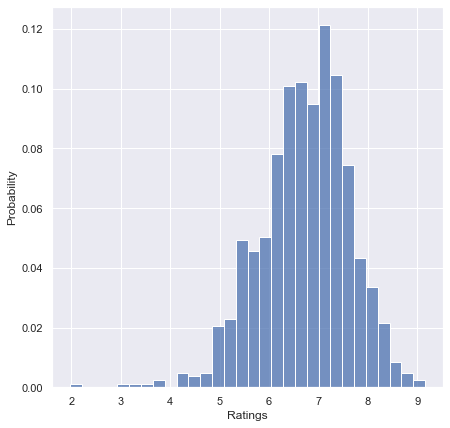

count    832.000000
mean       6.718954
std        0.906373
min        1.970000
25%        6.170000
50%        6.780000
75%        7.330000
max        9.160000
Name: score, dtype: float64

In [433]:
sns.histplot(df_sent['score'], stat = "probability")
plt.xlabel("Ratings")
plt.show()

df_sent['score'].describe()

Most of the ratings are centered around 7, in a similar fashion to how the polarity scores are centered around 0.2.

In order to compare them, let's normalize both of them between -1 and 1.

**Remark**: a compound score is by definition normalized between -1 and 1, but the series of those we actually computed is obviously not

In [686]:
pol_score = sent_analysis.norm_col(df_sent['polarity_score'], -1, 1)
anime_score = sent_analysis.norm_col(df_sent['score'], -1, 1)

Now we can produce a scatterplot of one *vs* the other

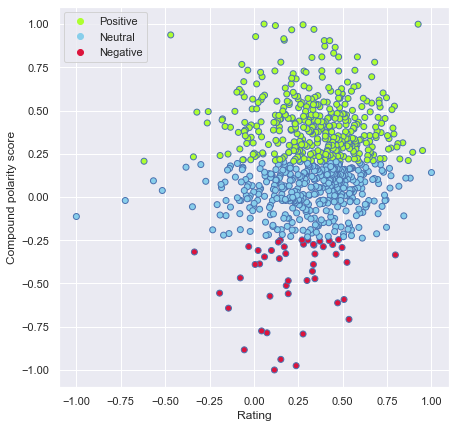

In [687]:
sent_analysis.sent_scatter(anime_score, pol_score, df_sent['sentiment'], 
                           xlabel = "Rating",
                           ylabel = "Compound polarity score").show()

There is no clear relationship between the two, and as we could expect the plot is denser around the medians of the two distributions, which are

In [413]:
print(f"Med(pol_score) = {np.median(pol_score):.2f}")
print(f"Med(anime_score) = {np.median(anime_score):.2f}")

Med(pol_score) = 0.17
Med(anime_score) = 0.34


If we compute the Pearson's R coefficient there doesn't in fact appear to be any (linear) relationship between the two

In [616]:
from scipy.stats import pearsonr

pearsonr = pearsonr(pol_score, anime_score)

print(f"R = {pearsonr[0]:.3f}")
print(f"p = {pearsonr[1]:.3f} < 0.05")

R = 0.095
p = 0.006 < 0.05


### What is the most popular type of anime?

In [477]:
df_sent.groupby('type').size()

type
Movie      130
Music       20
ONA         63
OVA        217
Special     72
TV         330
dtype: int64

Let's see if the proportion of Positive / Negative / Neutral changes among the six types; to do so we can compare the pie charts we get

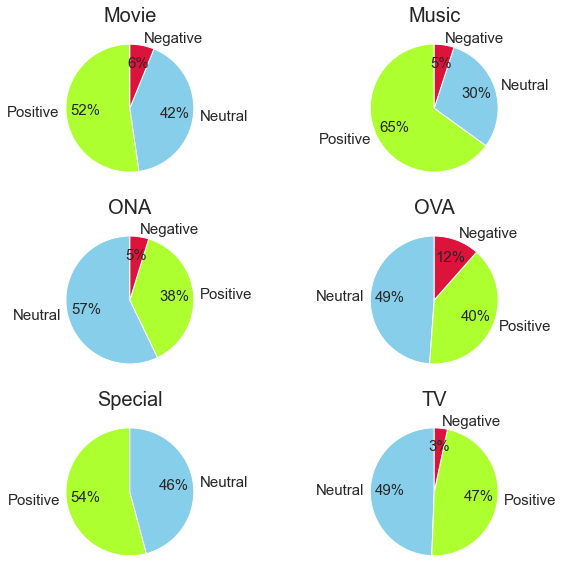

In [566]:
fig, axes = plt.subplots(3, 2, figsize = (10, 10))

sent_analysis.sent_multiple_pie_charts(df_sent, plt, axes)

plt.show()

By looking at these charts the most popular anime type seems to be the "Music" type (which is also the one with least number of entries); however – as we explained earlier – we would refrain from drawing conclusions from this analysis alone, which is only meant to give a rough idea.

### Is there any relationship between the polarity scores and the number of episodes?

In [620]:
num_episodes = np.array(df_sent[(df_sent['type'] == "TV") & 
                                (df_sent['episodes'] != 'None')]['episodes'],
                        dtype = int)

First, let's take an exploratory look into the distribution of the number of episodes, by only considering animes of type `TV` (otherwise we would observe a peak in 1 due to the other types).

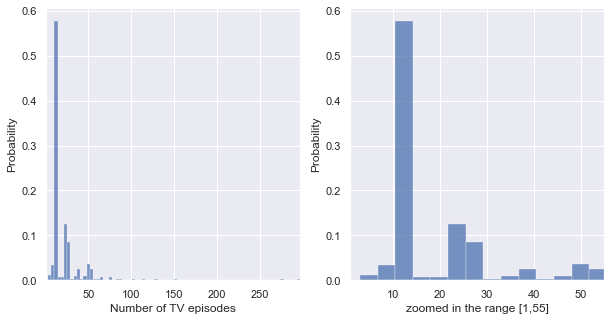

In [604]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

sns.histplot(num_episodes, stat = "probability", ax = ax1).set(xlim = (1, max(num_episodes)))
sns.histplot(num_episodes, stat = "probability", ax = ax2).set(xlim = (1, 55))

ax1.set_xlabel("Number of TV episodes")
ax2.set_xlabel("zoomed in the range [1,55]")

plt.show()

Most of the TV animes (among those we considered) have less than 50 episodes, with some noticeable peaks around 10 and 25.

Let's create a scatterplot with the respective polarity scores, focusing our attention only on that "zoomed in" range of episodes.

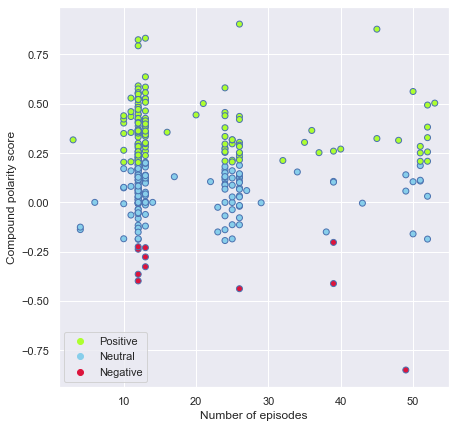

In [694]:
pol_score = np.array(df_sent[(df_sent['type'] == "TV") &
                             (df_sent['episodes'] != 'None')]['polarity_score'],
                     dtype = float)

sent = np.array(df_sent[(df_sent['type'] == "TV") & 
                        (df_sent['episodes'] != 'None')]['sentiment'],
                dtype = str)
    
sent_analysis.sent_scatter(num_episodes, pol_score, sent, 
                           xlabel = "Number of episodes",
                           ylabel = "Compound polarity score")

plt.xlim((1,55))
plt.show()

This plot shows the same behaviour we saw earlier: given a certain number of episodes, the polarity scores are spread out with no particular pattern across the vertical axis, hence we can conclude – with all due caution, as explained earlier – that there is no relationship between the number of episodes and how the anime was received.

## 5. Algorithmic question
You consult for a personal trainer who has a back-to-back sequence of requests for appointments. A sequence of requests is of the form > 30, 40, 25, 50, 30, 20 where each number is the time that the person who makes the appointment wants to spend. You need to accept some requests, however you need a break between them, so you cannot accept two consecutive requests. For example, [30, 50, 20] is an acceptable solution (of duration 100), but [30, 40, 50, 20] is not, because 30 and 40 are two consecutive appointments. Your goal is to provide to the personal trainer a schedule that maximizes the total length of the accepted appointments. For example, in the previous instance, the optimal solution is [40, 50, 20], of total duration 110.

* Write an algorithm that computes the acceptable solution with the longest possible duration.
* Implement a program that given in input an instance in the form given above, gives the optimal solution.


*SOLUTION*

* We started with a recursive algorithm which was correct but not optimal.



* Then, we decided to find a algorithm with linear running time.

    First of all, we found a solution to the sub-problem related to maximum sum of a sequence which elements were not consecutive: we implement an algorithm that takes into account two diffent variables a and b that store the sum of the elements considering the actual element as included or excluded. Simoultaneously, we create two different lists of tuples [ original= (element of original array, its index), step=(elements  of the array such that a+element>b,it index).

    We implemented a function able to eliminate all the elements of step if they were consecutive in original. Due to the structure of step, it made sense starting from the last element since we were certain that it was certainly in the final result.

**Note**: the algorithm does not discriminate different possible solution with the same sum

At the end, we compared the results of this two different algorithms with random array to be sure of the implementation.


In [1]:
def recursive_algo(arr):
    if len(arr)<2:
        return arr

    return(max(recursive_algo(arr[1:]), [arr[0]] + recursive_algo(arr[2:]), key=sum))

#recursive_algo(caso_limite)

In [4]:
def find_max_sum(array):
    '''
    find the max sum of elements that are not consecutive
    '''
    a=0
    b=array[0]
    original=[(array[0],0)]
    step=[(array[0],0)]
    index=1
    for elem in array[1:]:
        original.append((elem,index))
        n=max(a+elem,b)
        if a+elem>b:
            step.append((elem,index))
        index+=1
        a=b
        b=n

    
    return b,step,original

def eliminate_consecutive(step,original):
    '''
    eliminate the element from step which are consecutive in the original array
    '''
    i=0
    condizione=len(step)

    
    while -i<condizione:
        j=step[i-1][1]

        if (step[i-1][1]!=0 ):   
            if (step[i-2]==original[j-1]):
                step.pop(i-2)

        condizione=len(step)
        i-=1
        
    step=[x[0] for x in step]
    return step
    

def solutione(array):
    b,step,original=find_max_sum(array)
    step=eliminate_consecutive(step,original)
    return step


In [5]:
import random
for i in range(1000):
     k=random.randint(5,20)
     array=[random.randint(1,20) for _ in range(k)]
     assert sum(recursive_algo(array))==sum(solutione(array)),f"errore nel array {i} {array}"

In [7]:
solutione([40,50,40,40,40])

[40, 40, 40]